In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import xarray as xr
#import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from scipy.stats import binned_statistic_2d
from plot import PlotData

In [2]:
file = "./Daten/se_atlantic_df.csv"
df = pd.read_csv(file, index_col='time')
print(df)
print(f'Columns: \n {df.columns}') 

             lat  lon     clf   lwp         blh     cape     mlspf  \
time                                                                 
2011-01-02 -22.5  0.5  0.4090  42.0  1093.81670   0.0625  0.000000   
2011-01-02 -22.5  1.5  0.4736  84.0  1120.74900   0.0625  0.000000   
2011-01-02 -22.5  2.5  0.4375  78.0  1296.67750  23.3750  0.000000   
2011-01-02 -21.5  0.5  0.7204  45.0  1050.81710   0.0625  0.000000   
2011-01-02 -21.5  1.5  0.7309  35.0  1167.79440  23.3750  0.000000   
...          ...  ...     ...   ...         ...      ...       ...   
2019-12-31 -11.5  7.5  0.1795  53.0   781.37620   0.0625  0.000000   
2019-12-31 -11.5  8.5  0.2137  87.0   780.33594   0.0625  0.000000   
2019-12-31 -10.5  7.5  0.1584  44.0   824.37573   0.0625  0.014893   
2019-12-31 -10.5  8.5  0.0195  47.0   748.31740   0.0625  0.000000   
2019-12-31  -8.5  8.5  0.0186  69.0   736.18040  23.3750  0.000000   

                 mslhf      msshf      q700  ...      u850       v10  \
time             

Temporal Distribution of clf and lwp

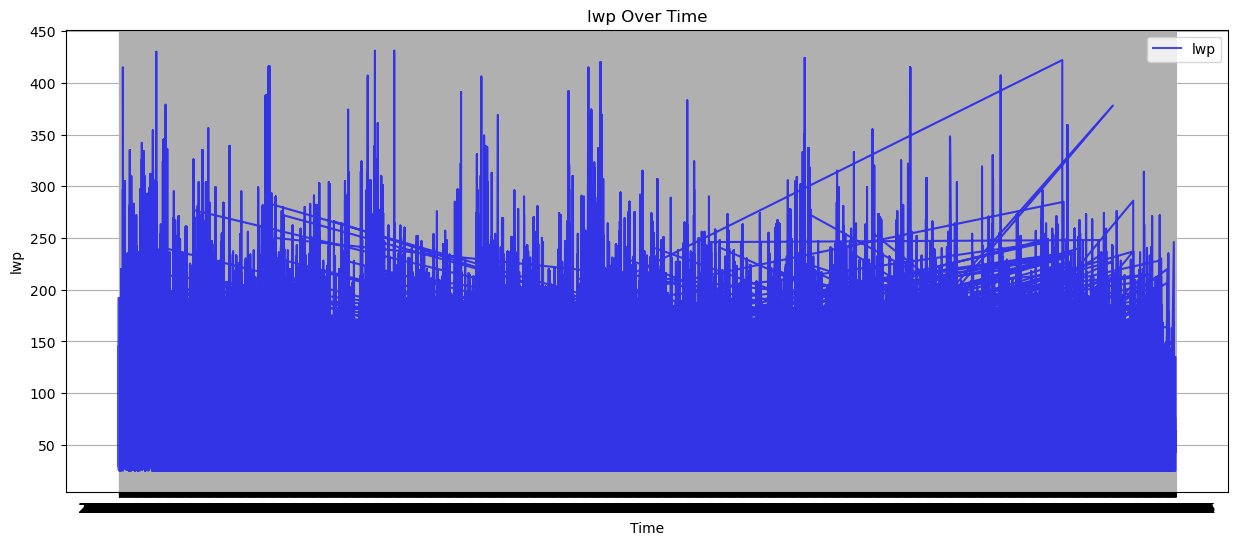

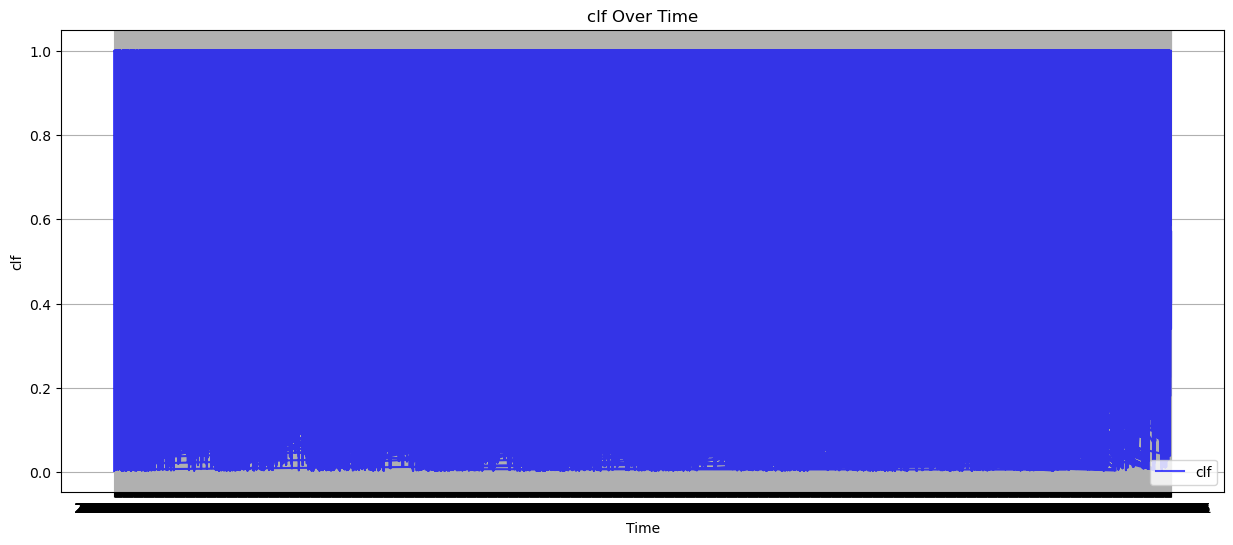

In [14]:
#plotting lwp over time
PlotData.temporal_plot('lwp')
#plotting clf over time
PlotData.temporal_plot('clf')

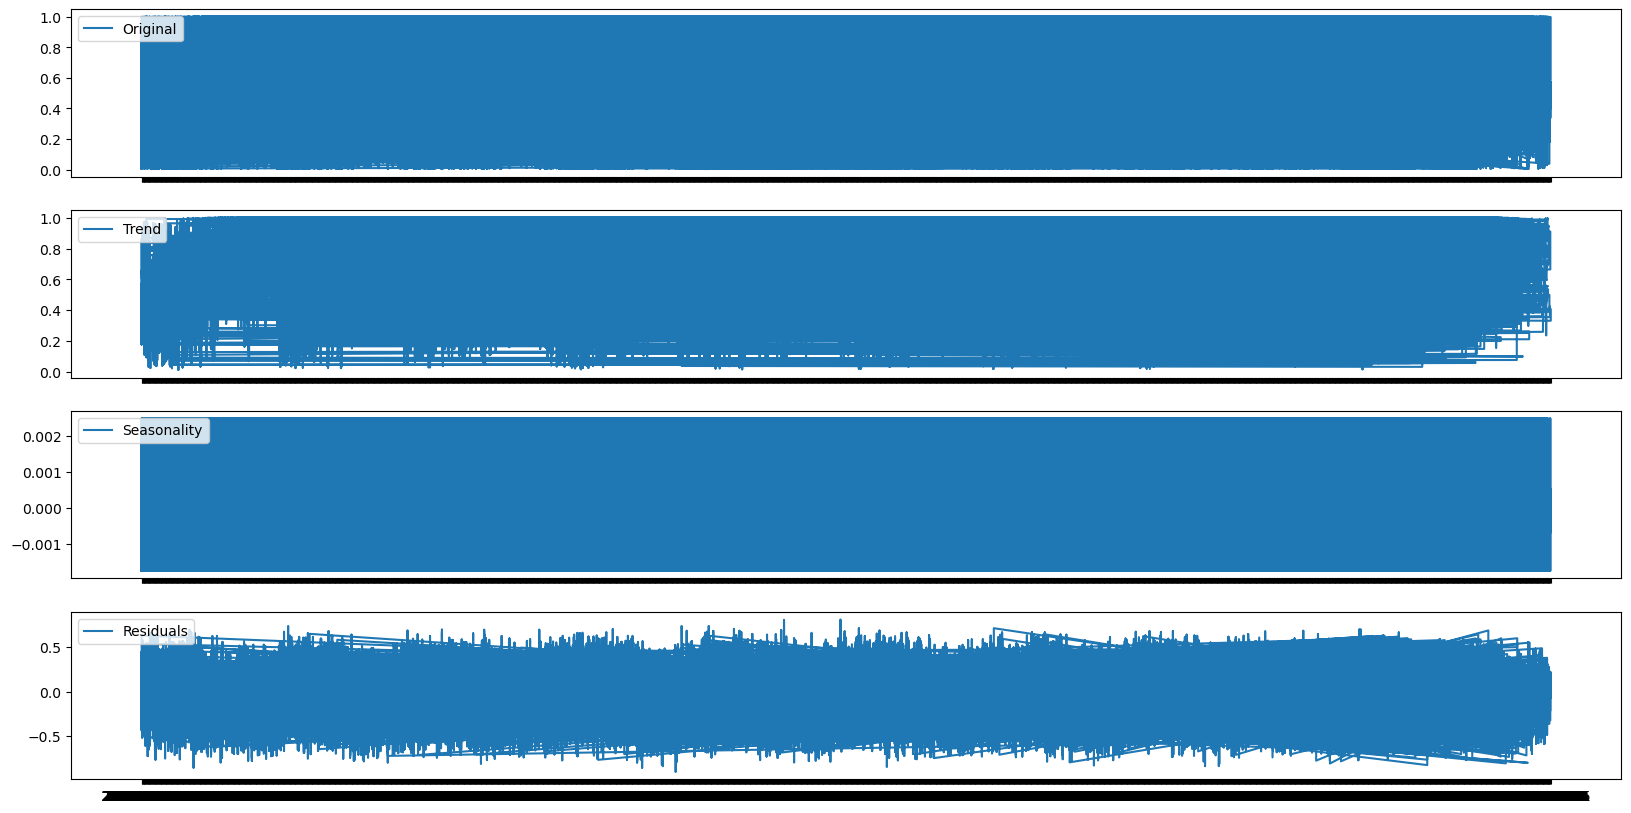

In [7]:
#Time series Decomposition Clf
from statsmodels.tsa.seasonal import seasonal_decompose

def ts_decomp (column:str):
    ts_decomp_clf = seasonal_decompose(df['clf'], model='additive', period=12 ,extrapolate_trend='freq')#period = 12) # we set the cyclic period of the seasonal cycle by hand
    trend_estimate = ts_decomp_clf.trend
    seasonal_estimate = ts_decomp_clf.seasonal
    residual_estimate = ts_decomp_clf.resid

# Plotting the time series and its individual components together
    fig, ax = plt.subplots(4, 1, sharex=True, sharey=False)
#fig, ax = plt.subplots(5, 1, sharex=True, sharey=False)

    fig.set_figheight(10)
    fig.set_figwidth(20)

    ax[0].plot(df['clf'], label='Original') 
    ax[0].legend(loc='upper left')

    ax[1].plot(trend_estimate, label='Trend')
    ax[1].legend(loc='upper left')

    ax[2].plot(seasonal_estimate, label='Seasonality')
    ax[2].legend(loc='upper left')

    ax[3].plot(residual_estimate, label='Residuals')
    ax[3].legend(loc='upper left')

In [20]:
# clfplot = PlotData (df,'clf')
# clfplot.ts_decompose('clf')

AttributeError: 'PlotData' object has no attribute 'ts_decompose'

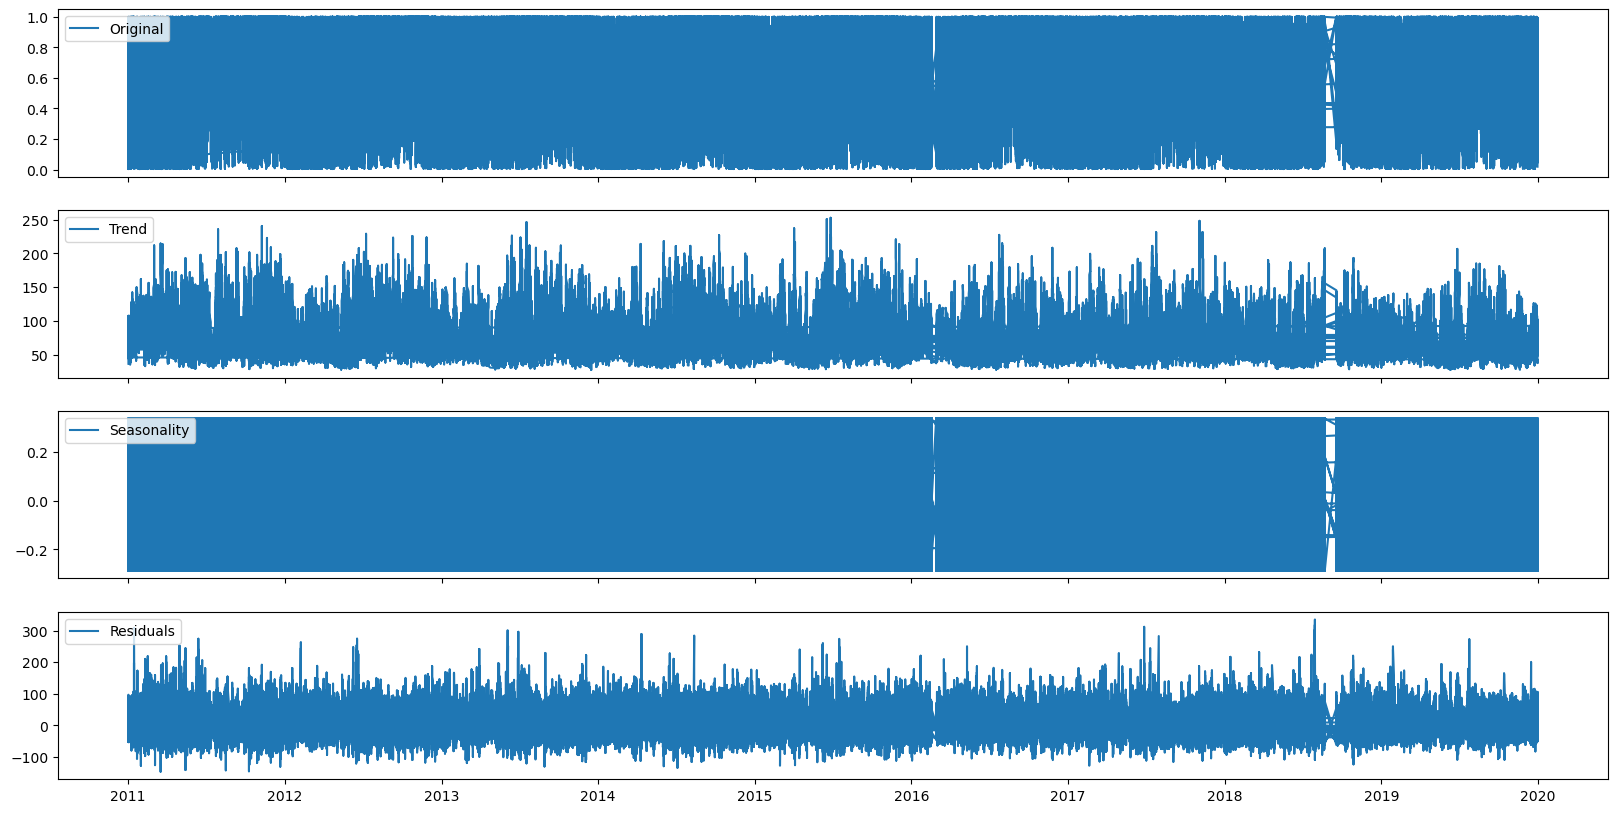

In [8]:
#Time series Decomposition LWP
from statsmodels.tsa.seasonal import seasonal_decompose

ts_decomp_lwp = seasonal_decompose(df['lwp'], model='additive', period=12 ,extrapolate_trend='freq')#period = 12) # we set the cyclic period of the seasonal cycle by hand
trend_estimate = ts_decomp_lwp.trend
seasonal_estimate = ts_decomp_lwp.seasonal
residual_estimate = ts_decomp_lwp.resid

# Plotting the time series and its individual components together
fig, ax = plt.subplots(4, 1, sharex=True, sharey=False)
#fig, ax = plt.subplots(5, 1, sharex=True, sharey=False)

fig.set_figheight(10)
fig.set_figwidth(20)

ax[0].plot(df['clf'], label='Original') 
ax[0].legend(loc='upper left')

ax[1].plot(trend_estimate, label='Trend')
ax[1].legend(loc='upper left')

ax[2].plot(seasonal_estimate, label='Seasonality')
ax[2].legend(loc='upper left')

ax[3].plot(residual_estimate, label='Residuals')
ax[3].legend(loc='upper left')



Spatial Distribution of LWP and CLF

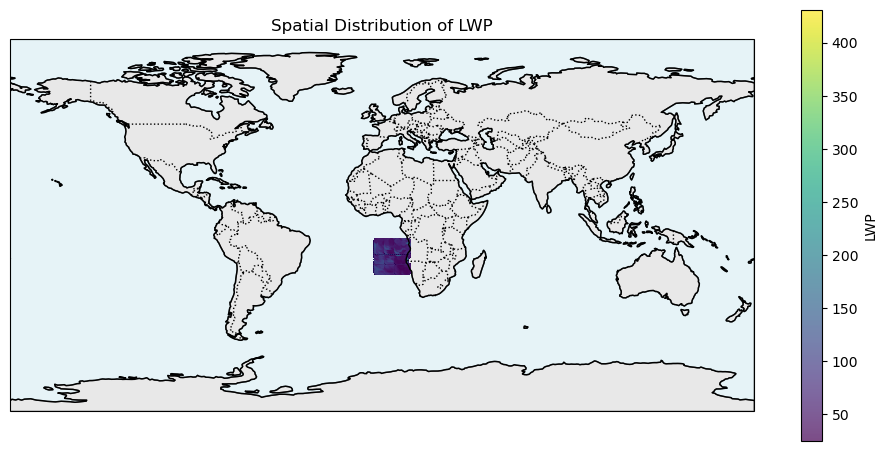

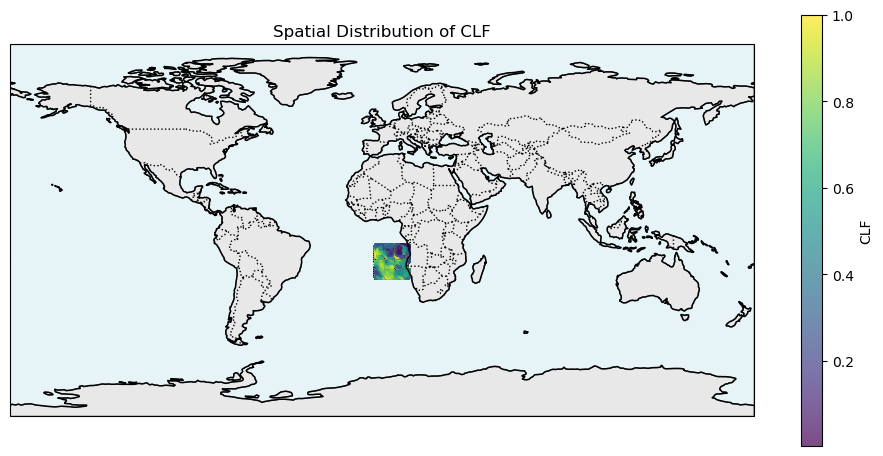

In [9]:
#calling the function from plot.py
#LWP
PlotData.spatial_plot_on_map(df, 'lwp', 'Spatial Distribution of LWP', 'viridis', 'LWP')
#CLF
PlotData.spatial_plot_on_map(df, 'clf', 'Spatial Distribution of CLF', 'viridis', 'CLF')

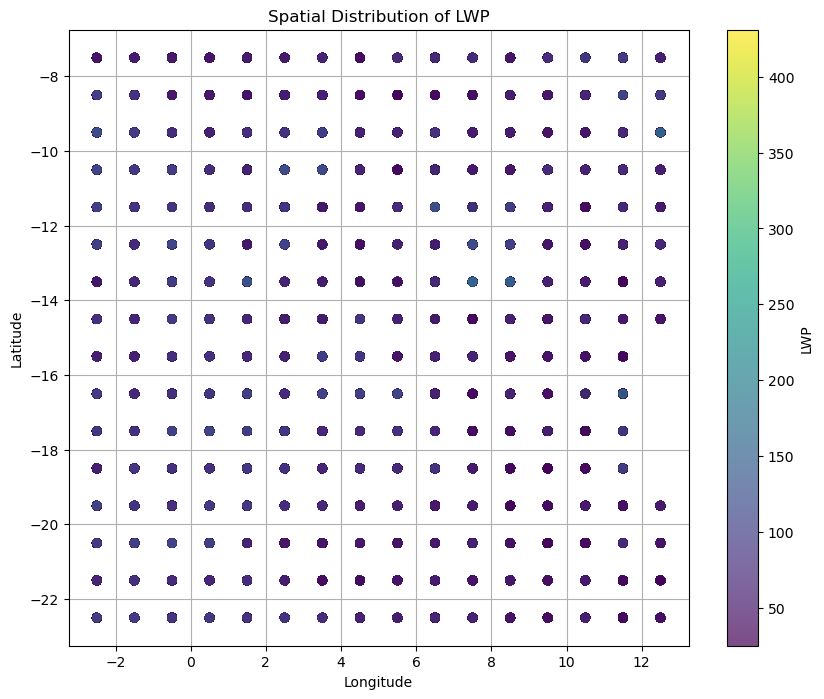

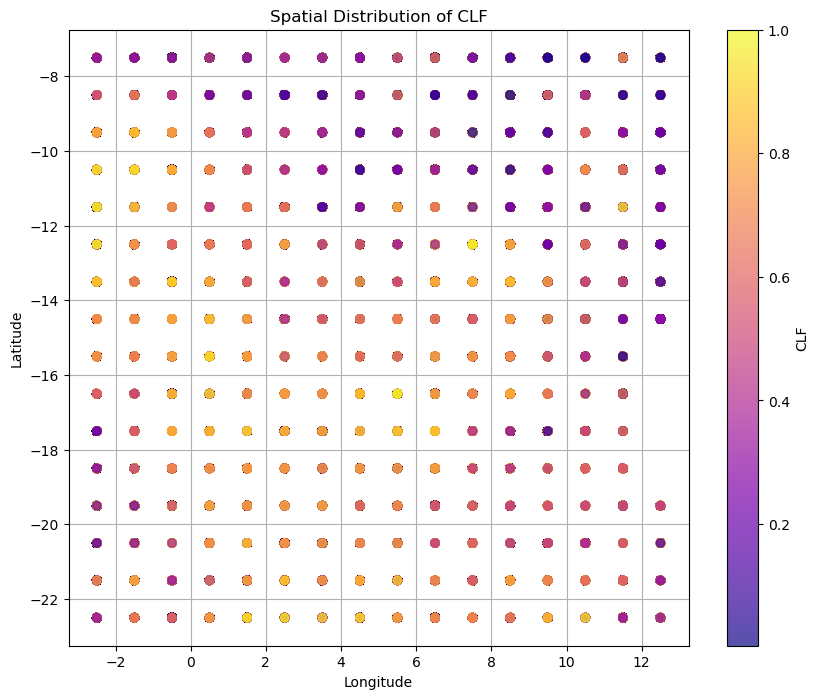

In [11]:
# 2. Spatial Scatter Plot for LWP
plt.figure(figsize=(10, 8))
sc = plt.scatter(df['lon'], df['lat'], c=df['lwp'], cmap='viridis', alpha=0.7)
plt.colorbar(sc, label='LWP')
plt.title('Spatial Distribution of LWP')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid()
plt.show()

# Spatial Scatter Plot for CLF
plt.figure(figsize=(10, 8))
sc = plt.scatter(df['lon'], df['lat'], c=df['clf'], cmap='plasma', alpha=0.7)
plt.colorbar(sc, label='CLF')
plt.title('Spatial Distribution of CLF')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid()
plt.show()

In [1]:
import numpy as np
import matplotlib.pyplot as plt


# Function to create a smooth gradient by binning the data
def create_smooth_grid(df, value_col, method='mean', bins=100):
    """
    Interpolates data onto a grid for smoother visualization.
    
    Parameters:
        df: DataFrame containing lat, lon, and the value column.
        value_col: The column to smooth (e.g., 'lwp', 'clf').
        method: Aggregation method ('mean', 'median', etc.).
        bins: Number of bins for latitude and longitude.
    
    Returns:
        lon_edges, lat_edges, grid: Longitude edges, latitude edges, and smoothed grid values.
    """
    lat = df['lat']
    lon = df['lon']
    values = df[value_col]
    
    statistic, lon_edges, lat_edges, _ = binned_statistic_2d(
        lon, lat, values,
        statistic=method, bins=bins
    )
    return lon_edges, lat_edges, statistic

# Function to plot a smooth heatmap on a map
def plot_smooth_map(df, column, title, cmap, colorbar_label, method='mean', bins=100, buffer=5):
    # Create smoothed grid
    lon_edges, lat_edges, grid = create_smooth_grid(df, column, method=method, bins=bins)

    # Calculate bounds with buffer
    bounds = get_bounds_with_buffer(df, buffer=buffer)

    # Plot on a map
    plt.figure(figsize=(12, 8))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent(bounds, crs=ccrs.PlateCarree())

    # Add map features
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgray', alpha=0.5)
    ax.add_feature(cfeature.OCEAN, edgecolor='black', facecolor='lightblue', alpha=0.3)

    # Plot the heatmap
    lon_center = (lon_edges[:-1] + lon_edges[1:]) / 2  # Get bin centers for longitude
    lat_center = (lat_edges[:-1] + lat_edges[1:]) / 2  # Get bin centers for latitude
    mesh = ax.pcolormesh(lon_center, lat_center, grid.T, cmap=cmap, shading='auto', transform=ccrs.PlateCarree())
    
    # Add colorbar
    plt.colorbar(mesh, label=colorbar_label, orientation="vertical", shrink=0.7)
    plt.title(title)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()

# Plot for LWP (smoothed with mean)
plot_smooth_map(df, 'lwp', 'Smoothed Spatial Distribution of LWP', 'viridis', 'LWP', method='mean', bins=100, buffer=5)

# Plot for CLF (smoothed with mean)
plot_smooth_map(df, 'clf', 'Smoothed Spatial Distribution of CLF', 'plasma', 'CLF', method='mean', bins=100, buffer=5)


NameError: name 'df' is not defined